# Exercise 6: Signal Averaging and Confidence Intervals
## Medical Signal Processing and Statistics (E010390)
### Dept of Information Technology (UGent) and Dept of Electronics and Informatics (VUB)
Sarah Verhulst

<font color=blue>Students names and IDs: </font> <Br>
<font color=blue>Academic Year </font>: 2022-2023

In [352]:
%matplotlib inline

'''
Use %matplotlib inline instead of %matplotlib widget when preparing the final report. 
Otherwise the images are, unfortunately, not embedded in the pdf. 
'''
from importstatements import *
from pylab import *
from scipy.signal import firwin, lfilter, filtfilt
from scipy.io import loadmat
import scipy as sci
import scipy.io
import scipy.signal as sig
css_styling()

FileNotFoundError: [Errno 2] No such file or directory: '../assets/styles/custom.css'

In [353]:
import numpy as np                # this need's no expl
from scipy import signal          #
from scipy import fftpack as fft
import math as math
import matplotlib.pyplot as plt
# import itertools                  # used to iterate over all combinations of parameters for a certain plot
# alternative: plotly - also for jupyterLab

## If you get an error on startup - in the command window, please install the following package
#pip install ipympl

## WAV files
from scipy.io import wavfile
import warnings                   # used to ignore some warnings in WAV-file reading
warnings.simplefilter(action='ignore', category=wavfile.WavFileWarning)

## HTML/CSS styling
from IPython.display import HTML
def css_styling():
    return HTML(open("../assets/styles/custom.css",'r').read())

## Plot parameters
#plt.ioff()                        # interactive mode off -- this means you need plt.show() to show the plots
#plt.rcParams['figure.figsize'] = [12, 8]
#plt.rcParams.update({'font.size': 22})

$
\newcommand{\fsamp}{{F_s}}
\newcommand{\tsamp}{{T_s}}
\newcommand{\unit}[1]{\ensuremath{\text{#1}}}
\newcommand{\tmidx}{n}
\newcommand{\tds}[2][\tmidx]{{#2(#1)}}
\newcommand{\matcmd}[2][(\cdot)]{\texttt{#2}#1}
\renewcommand{\matcmd}[2][(\cdot)]{\mathrm{#2}#1}
\newcommand{\fcn}[1]{{\text{#1}}}
\newcommand{\bigcb}[1]{{\big\{#1\big\}}} 
\newcommand{\Bigcb}[1]{{\Big\{#1\Big\}}}
\newcommand{\bigsb}[1]{{\big[#1\big]}} 
\newcommand{\Bigsb}[1]{{\Big[#1\Big]}}
\newcommand{\biggsb}[1]{{\bigg[#1\bigg]}}
\newcommand{\pyt}{\matcmd[]{Python}}
\newcommand{\fds}[2][z]{#2(#1)}
\newcommand{\zpow}[1][-1]{z^{#1}}
\newcommand{\cbr}[1]{\big\{#1\big\}}
\newcommand{\mat}[1]{\boldsymbol{#1}}
$

## General info
In this exercise, you will explore how signal averaging can be used to increase the signal-to-noise ratio of physiological recordings. We will estimate the confidence interval and noise floor on the recording to better interpret meaning of your signal. 

### Exercise 1: Signal Averaging and Artifact Rejection

In the first example, the biological signals you are to analyse are "otoacoustic emissions (OAEs)", which are sounds generated by the outer-hair-cells in the inner-ear. OAEs can be recorded using a sensitive microphone placed inside the ear-canal and are present when outer-hair-cells are intact and abscent when there is hearing damage. Because the test is quick and does not require participation of the subject, this test is used for new-born hearing screening in several countries. It is used as a "pass-fail" test in which OAE spectral energy above the noise floor is examined. If there is no OAE energy above the spectral noise floor, babies are referred for further testing. The figure shows a typical recording chain. 

https://en.wikipedia.org/wiki/Otoacoustic_emission

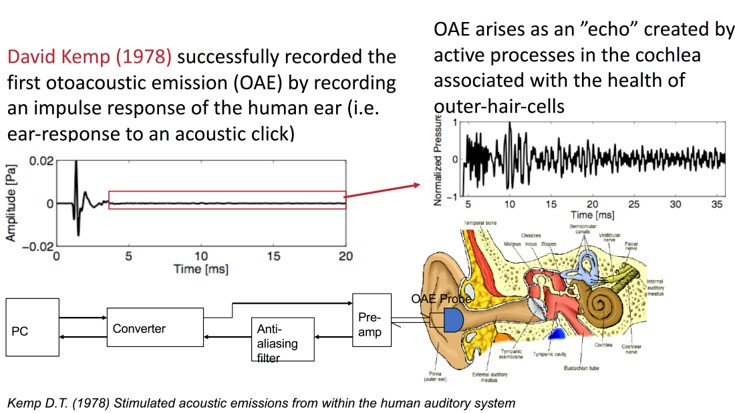

In practice, OAE signals are very faint (sounds of negative dB SPL, i.e. inaudible) and thus they are embedded within the biological body noise and surrounding sound which is also picked up by the microphone. To enable a robust recording to a specific stimulus, a signal averaging technique is used. Recordings to the same stimulus multiple times are averaged for a number of times; the technique assumes that the noise picked up by microphone is uncorrelated to the stimulus, while the signal of interest (the OAE), is correlated to the stimulus. Hence, the more averages, the better the signal-to-noise ratio. Practically, sounds are recorded for several minutes, while the stimulus is repeated for 400-2000 times. Given that the cochlear response to a click sounds only lasts 20-25 ms, the whole recording will only last several minutes. In the following exercise, the recorded ear-canal pressure (in Pa) is given in "OAE" and the stimulus click train is given in "Stim". 

In [357]:
Data = scipy.io.loadmat('S12CEOAE.mat')
FS = 48828.125 # sampling rate
PreAmpG = 40 
MicSens = 50e-3 #[50mV/Pa]
OAE=(Data['out']/MicSens)/10**(PreAmpG/20) # scaling of data
Stim=(Data['in'])
OAE = OAE[0]
Stim = Stim[0]

<div class="alert alert-info">

**Task**
        
* Get a feeling for your data: plot a 1s segment of both the OAE recording and Stimulus on seperate plots. Because the stimulus is a click (pulse) the stimulus signal can also be used as a trigger to realign the epochs. i.e. if there were 400 averages, there would be 400 pulses in the Stim signal, and you would have to cut your signal into 400 epochs, before you could averages the 400 responses and plot the mean OAE signal.

What your answer should look like.
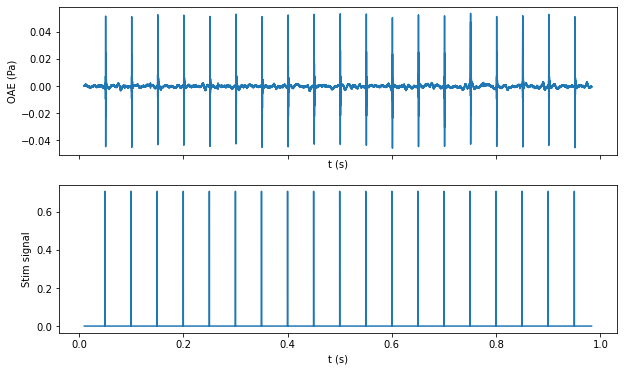

\tcbset{ frame code={} center title, left=0pt, right=0pt, top=0pt, bottom=0pt, colback=green!50, colframe=white, width=\dimexpr\textwidth\relax, enlarge left by=0mm, boxsep=5pt, arc=0pt,outer arc=0pt, }
<div class="alert alert-success">
<span style="color:black">
\begin{tcolorbox}
  
* Text answers go in this type of boxes
    
\end{tcolorbox}
    
</span>

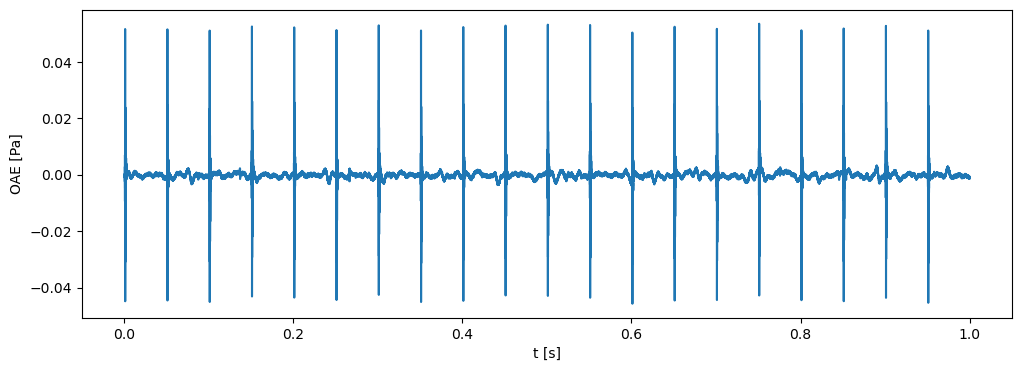

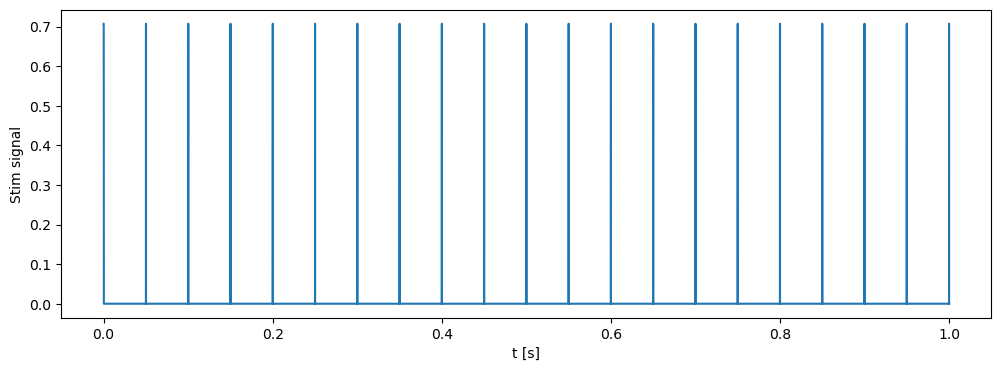

In [358]:
#Your code goes here
# OAE.shape -> (1, 1220511)
# Stim.shape ->(1, 1220500)

T = len(OAE)/FS
Time = np.linspace(0,1,len(OAE_1s))

OAE_1s = OAE[0:int(FS)] ## The data(OAE) within 1s
Stim_1s = Stim[0:int(FS)] ## The data(Stim) within 1s

fig = plt.figure(figsize=(12,4)); fig.clf()
ax = fig.add_subplot(111)
ax.plot(Time,OAE_1s)
plt.xlabel('t [s]')
plt.ylabel('OAE [Pa]')

fig = plt.figure(figsize=(12,4)); fig.clf()
ax = fig.add_subplot(111)
ax.plot(Time,Stim_1s)
plt.xlabel('t [s]')
plt.ylabel('Stim signal')

plt.show()

The OAE signal of interest is situated in between the recorded peaks. Because the responses have not yet been filtered, they are still embedded within low-frequency noise. Filtering should be done BEFORE you cut your data into epochs. The reason for this is that when you use a 0-phase filter (and sig.filtfilt) to filter your signal, you are using an non-causal filter. Hence, the first and last samples in your filtered signal are incorrect. If you first epoch and then filter, you risk bringing this filter error into each epoch (of 25 ms). However, if you filter the whole recording first, and then epoch, this error would only occur at the start and end of the recording. Irrespective of the order of the filtering or epoching steps, the shape of the filter (and its impulse-response duration) will affect smearing of impulse information in the signal. Hence it is important to adopt an appropriate filter for your application.

<div class="alert alert-info">

**Task**
        
* Implement a 0-phase filtering step that includes a 8th order butterworth filter with LP cut-off frequency of 4000 Hz and HP cut-off frequency of 600 Hz. You can either use sig.filtfilt, or the forward and reverse filtering approach. It might be necessary to apply first the HP filter and then afterwards the LP filter.

* Plot and investigate the characteristics of your filter(s). Plot the magnitude spectrum of the orignal data, and the filtered data, as well as the phase response of the original and filtered data, and the time-domain responses of filtered and unfiltered data, to make a motivated decision as to wether your filter worked.

What your answer should look like.
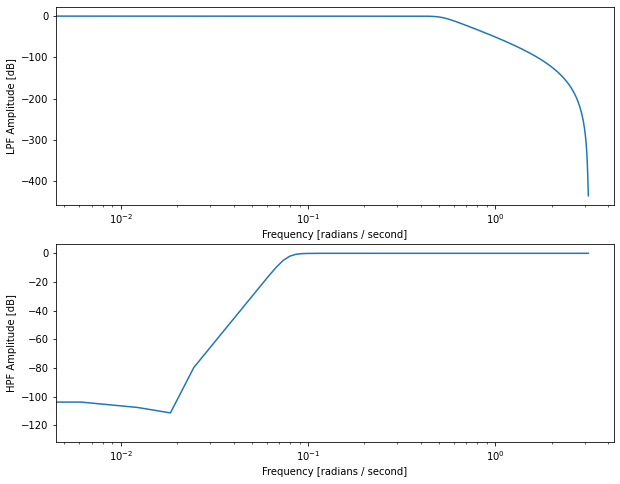

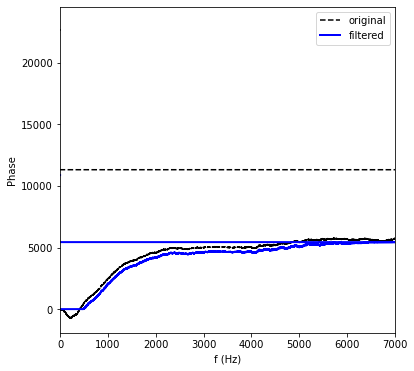

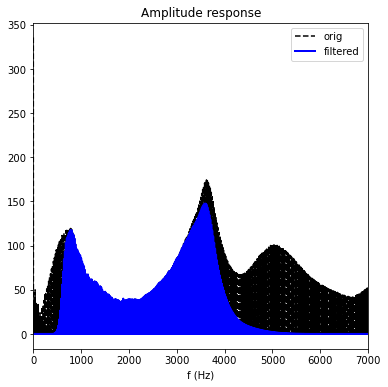

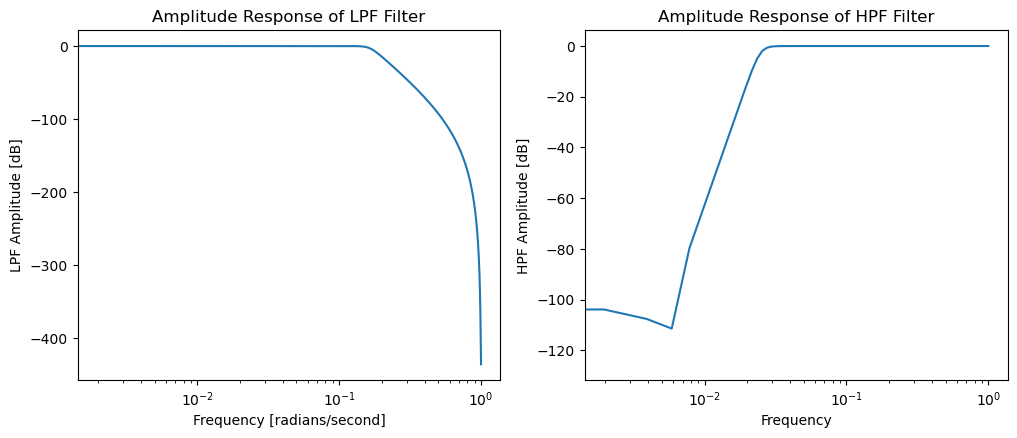

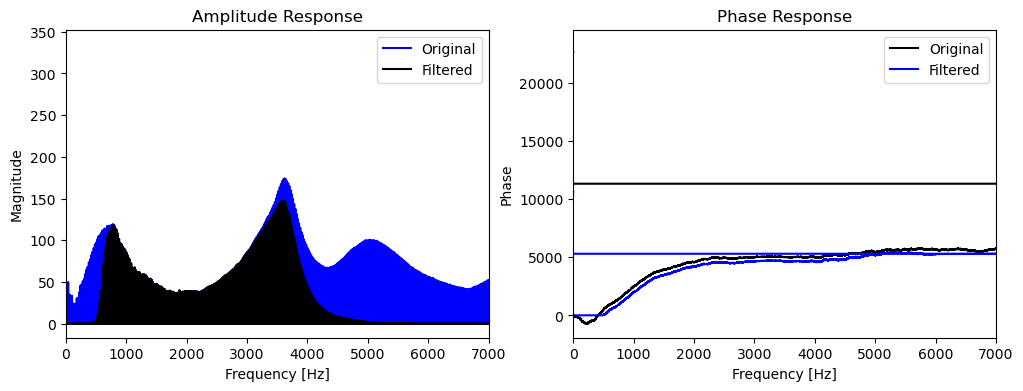

In [391]:
#Your code goes here
N = 8
Wn_LPF = 4000
Wn_HPF = 600
## LPF (Frequency response)##
LPF = signal.butter(N, Wn_LPF, btype='low', analog=False, output='ba', fs=FS)
B_LPF  = LPF[0]
A_LPF  = LPF[1]
w, h = signal.freqz(B_IIR_LPF,A_IIR_LPF,fs=FS)
Freq = np.linspace(0,1,len(w))
Amp, phase = 20*np.log10(np.abs(h)), np.angle(h) 

### Amplitude response (Check if the created filter works)### 
fig = plt.figure(figsize=(12,10)); fig.clf()
ax = fig.add_subplot(221)

plt.plot(Freq, Amp)
plt.title('Amplitude Response of LPF Filter')
plt.xlabel('Frequency [radians/second]')
plt.ylabel('LPF Amplitude [dB]')
ax.set_xscale('log')
### We check 

## HPF (Frequency response)##
HPF = signal.butter(N, Wn_HPF, btype='highpass', analog=False, output='ba', fs=FS)
B_HPF  = HPF[0]
A_HPF  = HPF[1]
w, h = signal.freqz(B_HPF,A_HPF,fs=FS)
Freq = np.linspace(0,1,len(w))
Amp, phase = 20*np.log10(np.abs(h)), np.angle(h) 

### Amplitude response ### 
ax = fig.add_subplot(222)
plt.plot(Freq, Amp)
plt.title('Amplitude Response of HPF Filter')
plt.xlabel('Frequency')
plt.ylabel('HPF Amplitude [dB]')
ax.set_xscale('log')

### 0 - phase filtering ###
### First HPF -> LPF
#### Remove frequency of less than 600Hz
output = signal.filtfilt(B_HPF,A_HPF,OAE)
#### Remove frequency of more than 4000Hz
filtred_OAE = signal.filtfilt(B_LPF,A_LPF,output)

#### Original signal : OAE
#### Filtered signal : filtred_OAE

#### Filtered OAE FFT
fft_filtered_OAE = np.fft.fft(filtred_OAE)
filteredQAE_freq = np.fft.fftfreq(OAE.size, 1/FS)
Amp_filtered_OAE = np.abs(fft_filtered_OAE)
Pha_filtered_OAE = np.unwrap(np.angle(fft_filtered_OAE))

#### Fon-filtered QAE FFT
fft_OAE = np.fft.fft(OAE)
OAE_freq = np.fft.fftfreq(OAE.size, 1/FS)
Amp_OAE = np.abs(fft_OAE)
Pha_OAE = np.unwrap(np.angle(fft_OAE))

### Amplitude and phase response of original and filtered signal
# w_ori, h_ori = signal.freqz(OAE)
# w_filtered, h_filtered = signal.freqz(output)
# なんでsignal.freqzつかえないんだよおおお
# Amp_ori = np.abs(h_ori)
# Amp_filtered = np.abs(h_filtered)
# Phase_ori = np.angle(h_ori)
# Phase_ori = np.unwrap(Phase_ori)
# Phase_filtered = np.angle(h_filtered)
# Phase_filtered = np.unwrap(Phase_filtered)


# Amplitude response 
fig = plt.figure(figsize=(12,4));
ax = fig.add_subplot(121)
plt.plot(OAE_freq, Amp_OAE,color = "b")
plt.plot(filteredQAE_freq, Amp_filtered_OAE,color = "k")
plt.title('Amplitude Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.xlim((0,7000))
plt.legend(["Original","Filtered"])

# Phase response 
ax = fig.add_subplot(122)
plt.plot(OAE_freq, Pha_OAE,color = "k")
plt.plot(filteredQAE_freq, Pha_filtered_OAE,color = "b")
plt.title('Phase Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase')
plt.xlim((0,7000))
plt.legend(["Original","Filtered"])

plt.show()


### For the next task ###

# First HPF -> LPF
# Remove frequency of less than 600Hz
output = signal.filtfilt(B_HPF,A_HPF,OAE)
# Remove frequency of more than 4000Hz
OAE_fil = signal.filtfilt(B_LPF,A_LPF,output)

After filtering the time-domain OAE recording, we can start on the **epoching** step which cuts the recording into epochs (or trials) that are marked by a stimulus click onset. The epoching step will make it easier to perform the averaging in the next step, as it aligns the trials in a matrix of shape $N  x  t_{\text{trial}}$ where $t_{\text{trial}}$ corresponds to the 50-ms duration of an epoch, and 500 to the number of stimulus repetitions in the experiment.

<div class="alert alert-info">
    
**Task**
        
* Use the np.reshape function to reshape the first $X$ samples of your filtered time-domain response into: 500 averages x epoch duration in samples. Determine $X$ such that the reshape function works, it can only recast the exact same number of samples in different dimensions, and your OAE recording was not turned off exactly right after the last epoch was recorded.

* Perform this epoching operation separately on the filtered recording and on the non-filtered recording. Then, make two subplots, one in which you plot all filtered epochs on top of each other (x-axis = time), and one on which you plot all non-filtered epochs on top of each other. Make another plot on which you compare the mean signal of the filtered epochs, and the mean signal of the non-filtered epochs. Explain why it is important to perform filtering averaging the epochs?

What your answer should look like.
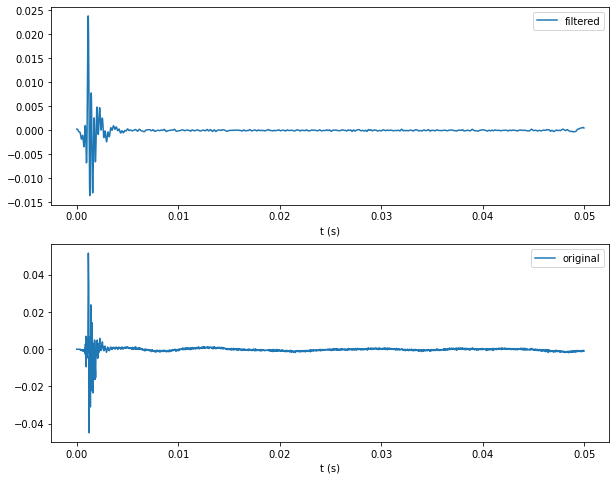

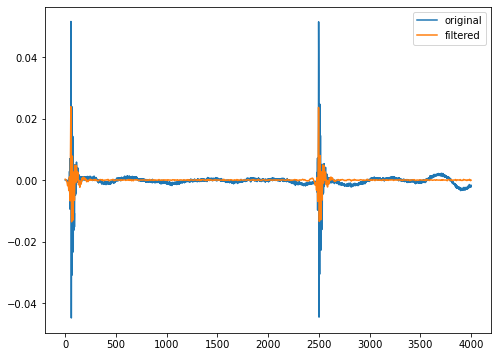

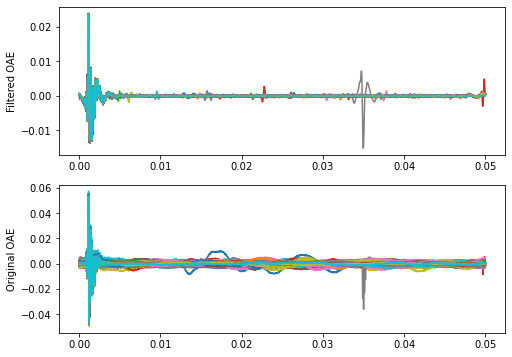

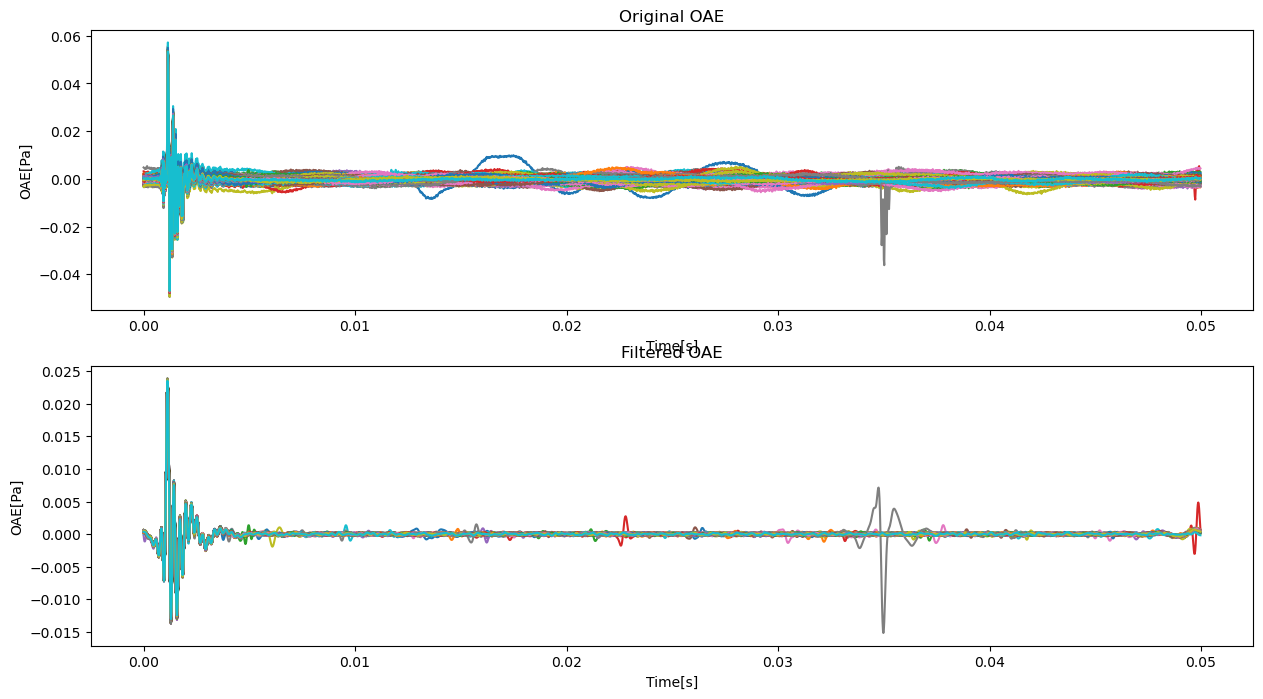

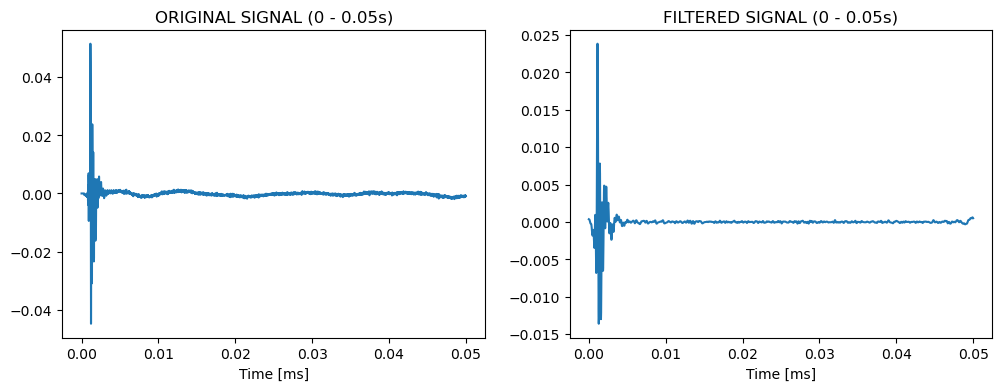

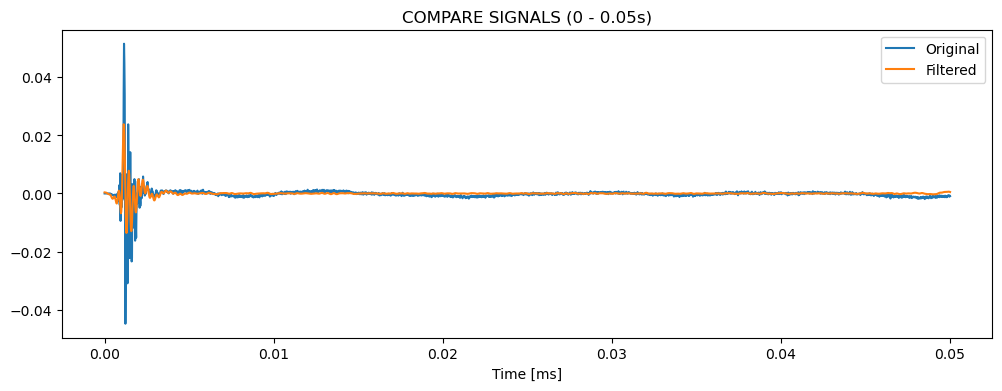

array([[ 0.00037172,  0.00036146,  0.00035141, ...,  0.00058723,
         0.0005513 ,  0.00050606],
       [ 0.00045408,  0.0003968 ,  0.00033414, ...,  0.0005419 ,
         0.00046128,  0.00038746],
       [ 0.00032249,  0.00026623,  0.00021594, ...,  0.00049756,
         0.00046447,  0.0004318 ],
       ...,
       [ 0.00053171,  0.00055564,  0.00056621, ...,  0.00044823,
         0.00043921,  0.0004448 ],
       [ 0.0004602 ,  0.00047621,  0.00048054, ...,  0.00043175,
         0.00040078,  0.00037483],
       [ 0.00035531,  0.00034056,  0.00032559, ..., -0.00015239,
        -0.00016611, -0.0001721 ]])

In [419]:
#Your code goes here
# fil_sig.shape(48828,) # The number of data in 1s
# OAE.shape(1220511,) # The number of data in 25s(whole length of time)
# T = len(OAE)/FS # used to check how long the whole length of time (25s)
# OAE_1s : original sig (1s)

ep_dur = int(len(OAE_1s)*0.05) # fil_sig <->OAE_1s (2441 = the number of data in 0.05s)
avg_500 = data_500 = int(len(OAE)/ep_dur) # 1220511 / 2441 = 500.0045 (prepare for determing 500)
# ORIGINAL SIGNAL DATA
# Determine X and reshape X into (500*2441)
#
X_ori = OAE[0:data_500*ep_dur] # OAE[0:500*2441]
ori_re = X_ori.reshape(data_500,ep_dur) #(500,2441)
# なにをしているのか、ざっくりせつめいするとオリジナルデータ（1220511）こある
#　データを2441このデータを一個のグループとして500グループ作っている
# イメージですね
X_fil = OAE_fil[0:data_500*ep_dur]
fil_re = X_fil.reshape(data_500,ep_dur)



fig,ax = plt.subplots(2,1,figsize = (15,8))
for i in range(500):
    ax[0].plot(Time[:int(FS/20)],ori_re[i])
    ax[0].set_xlabel("Time[s]")
    ax[0].set_ylabel("OAE[Pa]")
    ax[0].set_title("Original OAE")
    
    ax[1].plot(Time[:int(FS/20)],fil_re[i])
    ax[1].set_xlabel("Time[s]")
    ax[1].set_ylabel("OAE[Pa]")
    ax[1].set_title("Filtered OAE")

# Plot
x_time = np.linspace(0,0.05,ep_dur)
fig = plt.figure(figsize = (12,4));fig.clf()
ax = fig.add_subplot(121)
plt.plot(x_time,a_0_ori)
plt.title("ORIGINAL SIGNAL (0 - 0.05s)")
plt.xlabel("Time [ms]")

# FILTERED SIGNAL DATA
X_fil = OAE_fil[0:row_500*ep_dur] # OAE[0:500*2441]
a_fil = X_fil.reshape(avg_500,ep_dur) #(500,2441)
a_0_fil = a_fil[0,:]

# Plot 
ax = fig.add_subplot(122)
plt.plot(x_time,a_0_fil)
plt.title("FILTERED SIGNAL (0 - 0.05s)")
plt.xlabel("Time [ms]")

# Plot both 
x_time = np.linspace(0,0.05,ep_dur)
fig = plt.figure(figsize = (12,4));fig.clf()
ax = fig.add_subplot(111)
plt.plot(x_time,a_0_ori)
plt.plot(x_time,a_0_fil)
plt.title("COMPARE SIGNALS (0 - 0.05s)")
plt.xlabel("Time [ms]")
plt.legend(["Original","Filtered"])
plt.show()


# For the next task
epochs = fil_re

Even though the filtered epochs look smooth (i.e. no longer visible low-frequency fluctuations), you might still notice that there are "artifact/peaks" sticking out of the recordings. These artifacts are due biological noise (movement, breathing, face-touching,..) during the recordings and it is common practice to remove epochs with such artifacts before averaging. If the recordings are fairly short (e.g. as in OAEs), it is common to remove a fixed percentage of recorded epochs with the largest amplitudes (i.e. artifacts). This might end up removing too many or too few epochs, so it is a rough metric and other, more sensitive, methods can be used in more sophisticated approaches.

<div class="alert alert-info">
    
**Task**
        
* Make an automatic artifact rejection routine which rejects 5% of the epochs with the largest amplitudes within the 5 ms - 50 ms window of the recordings. The OAE signal of interest occurs after the click-response in the epoch (i.e. after 5 ms), and hence we should only remove those epochs with artifacts in that part of the recording. You can take the following steps to make this automatic rejection algorithm. 
    * identify the maximum amplitude in the 5-50 ms window of each epoch (np.max)
    * find the indices of the epochs belonging to these maxima and sort them in ascending order (np.argsort).
    * plot all the sorted maxima in ascending order, and observe whether the 5% limit will remove most of the epochs with artifacts in them.
    * remove 5% of the (noisiest) epochs, and plot all epochs on top of each other, compare to before (are the epochs with visual artifacts gone?)
    * compare the means of the epochs before artifact rejection, and after artifact rejection. You can zoom in on an OAE section to see what happens at a time-location that corresponded to a observed artifact in the average time-domain response.

What your answer should look like.
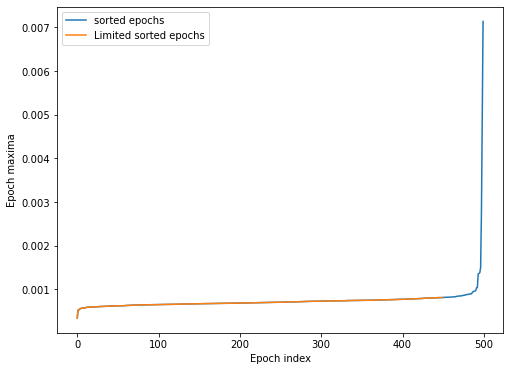

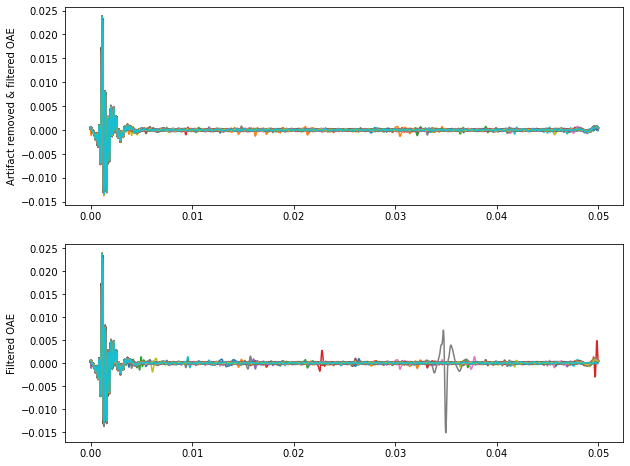

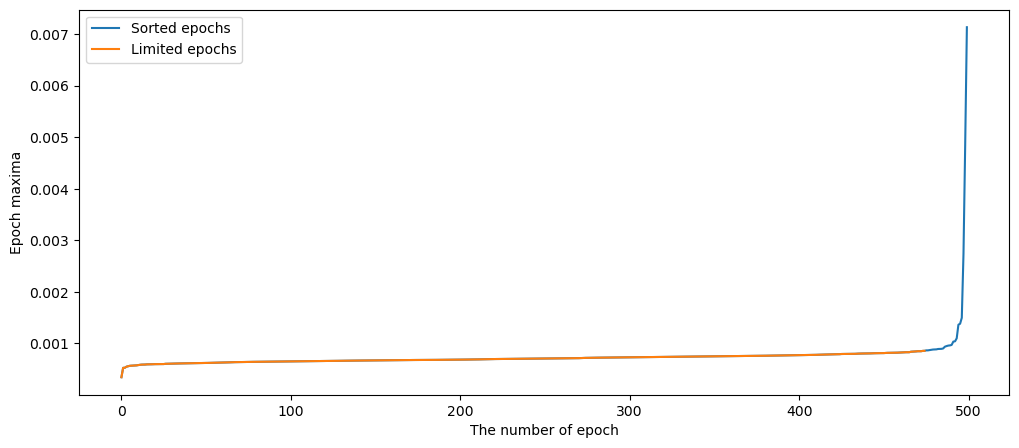

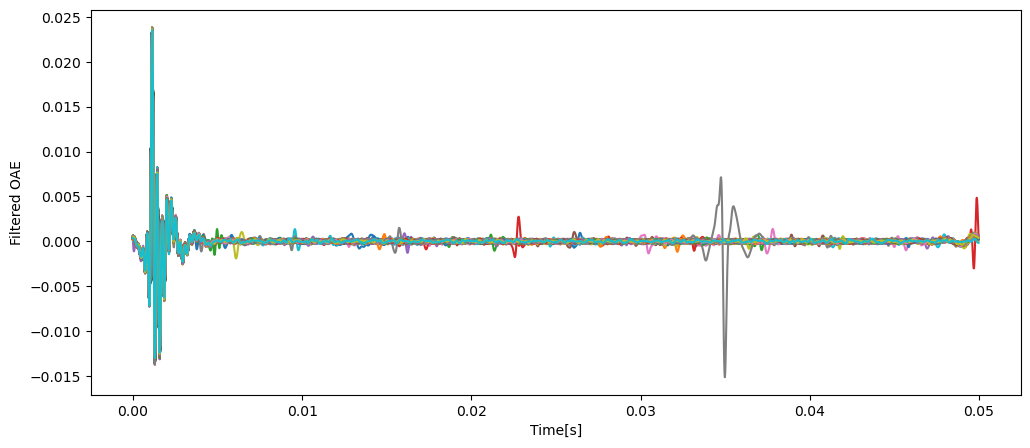

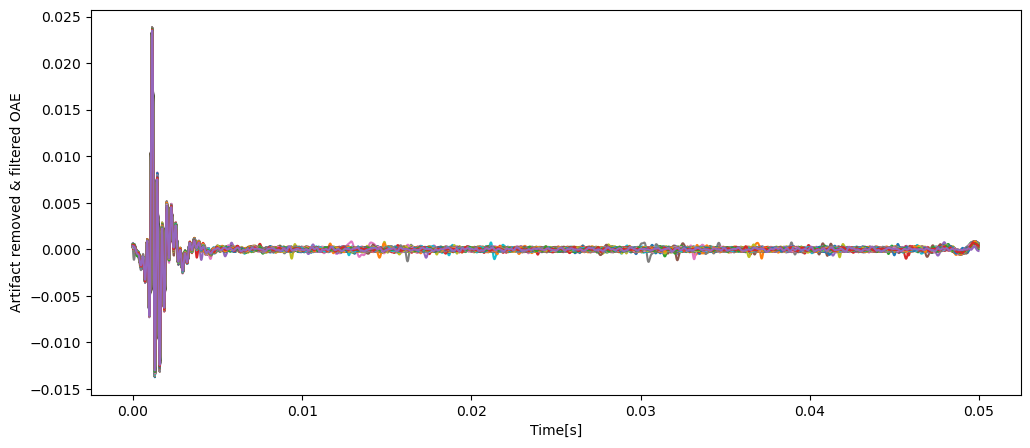

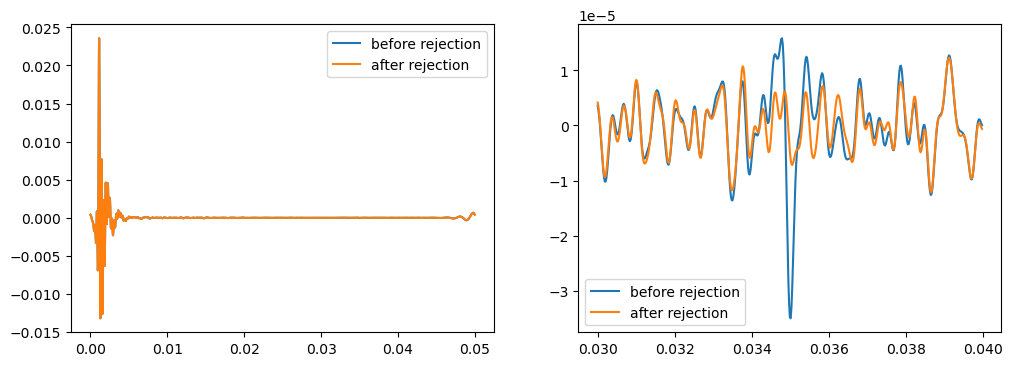

In [590]:
#Your code goes here

# Within 5ms - 50ms
# 5ms
ms_5 = int(len(OAE_1s)*0.005)
ms_50 = int(len(OAE_1s)*0.05)
# Identify the max amp of each epoch

maxs = []
for i in range(500):
    ep = epochs[i]
    max = np.max(ep[ms_5:ms_50])
    maxs.append(max)

indices = np.argsort(maxs)
sorted_maxs = np.sort(maxs)

num = int(500 * 0.95)
limit = sorted_maxs[0:num]


# Limitation of epochs
fig = plt.figure(figsize = (12,5));fig.clf()
ax = fig.add_subplot(111)
plt.plot(sorted_maxs)
plt.plot(limit)
plt.xlabel("The number of epoch")
plt.ylabel("Epoch maxima")
plt.legend(["Sorted epochs","Limited epochs"])

# Observe between before removed and afteer removed

# Firstly removing 
removed_indices = indices[num:500]
index_l = removed_indices.tolist()
removed_epochs = np.delete(epochs,index_l,0)

fig,ax = plt.subplots(1,1, figsize = (12,5))
for i in range(500):
    ax.plot(Time[:int(FS/20)],epochs[i])
    ax.set_xlabel("Time[s]")
    ax.set_ylabel("Filtered OAE")
    
fig,ax = plt.subplots(1,1, figsize = (12,5))   
for i in range(475):
    ax.plot(Time[:int(FS/20)],removed_epochs[i])
    ax.set_xlabel("Time[s]")
    ax.set_ylabel("Artifact removed & filtered OAE")
    

# Compare the means of epochs before and after rejection
mean = np.mean(epochs,axis=0)
mean_rej = np.mean(removed_epochs,axis = 0)

# Aritifacts can be seen between 0.03 and 0.04
ms_30 = int(len(OAE_1s)*0.03)
ms_40 = int(len(OAE_1s)*0.04)
a = mean[ms_30:ms_40]
b = mean_rej[ms_30:ms_40]

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
plt.plot(Time[0:int(FS/20)],mean)
plt.plot(Time[0:int(FS/20)],mean_rej)
plt.legend(["before rejection", "after rejection"])

ax = fig.add_subplot(122)
plt.plot(Time[ms_30:ms_40],a)
plt.plot(Time[ms_30:ms_40],b)
plt.legend(["before rejection", "after rejection"])

# for the next slide 
mean = mean_rej

In [529]:
## Don't delete this!!
# a=np.array([[1,2],[3,4],[5,6]])
# mean = np.mean(a,axis = 0)
# print(mean)
# a

[3. 4.]


array([[1, 2],
       [3, 4],
       [5, 6]])

### Exercise 2: Confidence Intervals and Noise Floors

After filtering and noise reduction, it is now time to interpret the averaged OAE signal. Is your average OAE signal meaningfull or noise? To make this assessment, you can calculate the confidence interval of the mean OAE signal. Once you have the confidence interval of signal, you can also interpret it statistically (i.e. is one signal significantly larger than another? If their confidence intervals do not overlap, you can conclude this). To calculate the confidence interval, we can make use of **(i)** the *central limit theorem (CLT)* that states that the mean of a sufficiently large number of independent random variables, each with a finite mean and variance will approximately be normally distributed, or **(ii)** the data at hand by applying resampling (a non-parametric bootstrap).

The CLT conclusion—that the OAE at each moment in time is approximately normally distributed—is useful because the normal distribution can be completely specified with two parameters: the mean value and the standard deviation. Second, 95% of the values drawn from a normal distribution lie within approximately two standard deviations of the mean.

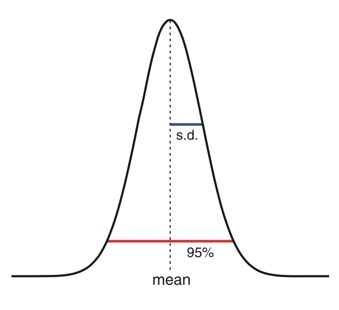

Note that for the purpose of OAE or EEG signals, the *mean* refers to the *sample mean*, because we use the observed data to estimate the theoretical mean that we would see if we kept repeating the experiment. We are hence not interested in the standard deviation of the EEG data across trials, but rather, we are interested in the standard deviation of the *estimate of the mean*. This makes a difference, because we can in this case use the *standard error* rather than the standard deviation of the data. The *standard deviation of the mean (or standard error)* is obtained by dividing the standard deviation of the data by the square root of the number of trials (i.e., the number of terms used to compute the mean):  
$$ (S.E. =\frac{s.d.}{\sqrt{N}})$$ 
where N equals the number of epochs.

<div class="alert alert-info">
    
**Task**
        
* The central limit theorem assumes that the epochs are independent (i.e., one trial does not depend on any other trial) and that at each moment in time, the recording has a finite mean and variance. Argue whether or not you think that this is a reasonable assumption for the OAE data? 

* Use the *standard deviation of the mean* concept to calculate and plot the 95\% confidence interval around your mean OAE waveform (i.e. for each sample of your OAE waveform). To this end, you can plot two additional curves along with the mean curve (one that marks the bottom of the confidence interval, and one that marks the top of the confidence interval). 
    
* You may have to zoom into your plot to observe the mean OAE and its confidence interval. 

What your answer should look like.
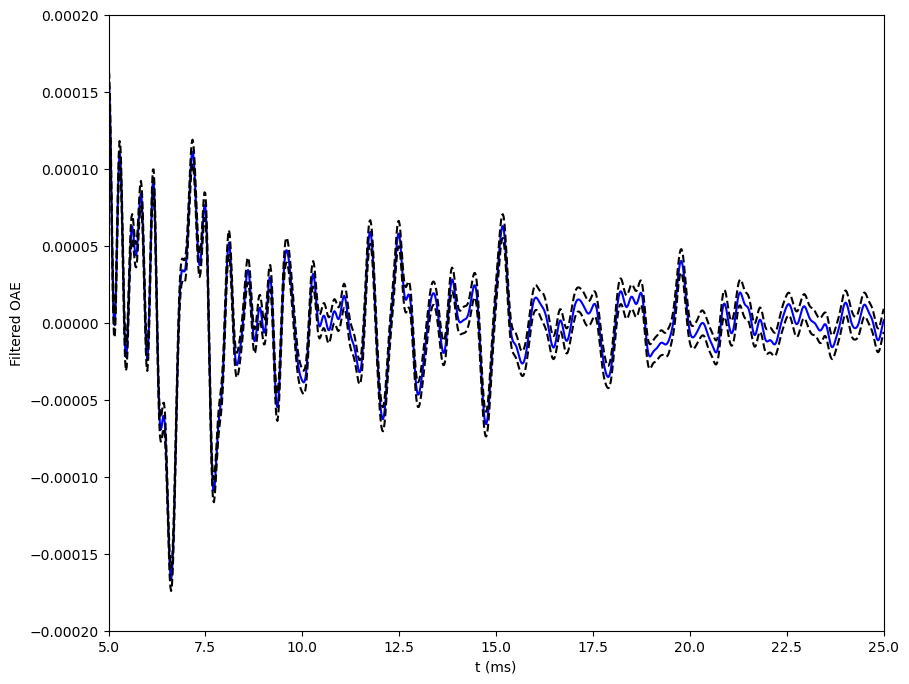

Text(0, 0.5, 'Filtered OAE')

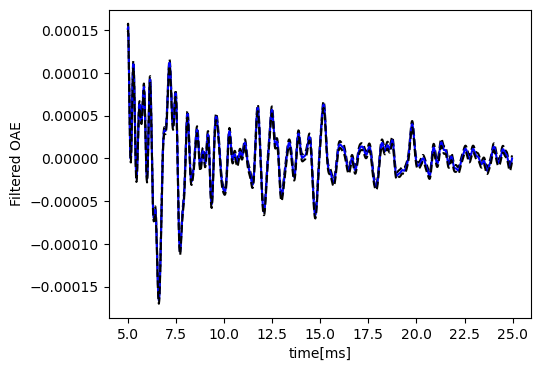

In [592]:
#Your code goes here
# calculate the standard deviation of the MEAN
std = np.std(removed_epochs,axis = 0)
### 不要な部分をなくしたtrailデータのなかで時間軸でstandard deviationをする
N = 475 # The number of trails
CI_top = mean + (std/N**0.5)
CI_bottom =  mean - (std/N**0.5)
sd = (std/N**0.5)
ms_5 = int(len(OAE_1s)*0.005)
ms_25 = int(len(OAE_1s)*0.025)

fig = plt.figure(figsize = (12,4))
ax = fig.add_subplot(121)
plt.plot(Time[ms_5:ms_25]*1000,CI_top[ms_5:ms_25],linestyle = "dashed",color = "k")
plt.plot(Time[ms_5:ms_25]*1000,mean[ms_5:ms_25], color = "b")
plt.plot(Time[ms_5:ms_25]*1000,CI_bottom[ms_5:ms_25],linestyle = "dashed",color = "k")
plt.xlabel("time[ms]")
plt.ylabel("Filtered OAE")

Next, we implement a *nonparametric bootstrap* to create the confidence intervals. In this method, we we generate new *pseudodata* from the observed OAE data rather using the central limit theorem directly. The fundamental, theoretical idea behind bootstrapping is that resampling the data with replacement is equivalent to sampling new pseudodata from the empirical cumulative distribution function (eCDF) of the observed data. For a large sample of independent, identically distributed random variables, the distribution of the pseudodata generated from the eCDF will be close to the true distribution of the data. Note the important caveat that the variables are independent, identically distributed; this assumption fails in many cases, such as for time series. Here, we assume that each trial is drawn independently from the same distribution (i.e., the epochs are independent, identically distributed variables).

The bootstrapping procedure is used to compute pointwise confidence intervals (i.e., separately for each point in time. You can follow the below steps to implement the bootstrapping procedure.

* Sample with replacement (np.random.choice) 450 epochs of the OAE data matrix (after artifact rejection)
* Average these 450 trials to create a resampled OAE.
* Repeat these two steps 1350 times to create a distribution of resampled mean OAE time-domain waveforms.
* For each time point, identify the values greater than 2.5% and less than 97.5% of all 1350 values (np.argsort). This range determines the 95% confidence interval for the OAE for that time point.   

<div class="alert alert-info">
    
**Task**
        
* Use the *bootstrapping* concept to calculate and plot the 95\% confidence interval around your mean OAE waveform (i.e. for each sample of your OAE waveform). To plot a shaded area with the CI around the mean curve you can modify the below piece of code. Again, make sure to make include that zoom into relevant aspects of the OAE data (between 5 and 45 ms).
    fig, ax = plt.subplots(1,1,sharex=True)
    ax.fill_between(tOAE, CI025[:,0], CI975[:,0],color='C0')
    ax.plot(tOAE,MOAE,color='k')
    
* You can use the confidence interval of the recording to generate a noise-floor on your time domain waveform above which mean OAE waveform excursions are significant. You can visualize noise floor by centering the CI you caclulated earlier around the 0-axis. Approximately in which time windows between 5 and 40 ms is has the mean OAE significant energy? 

* Next compare to which degree the CI calculations from method **(i)** and **(ii)** are equivalent, by making a plot that compares the two methods. Do you notice marked differences between the two calculation methods? Why (not)?

What your answer should look like.
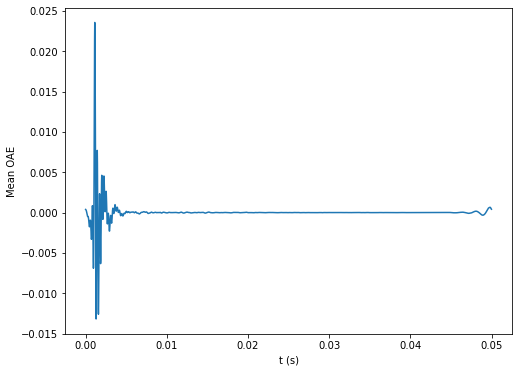

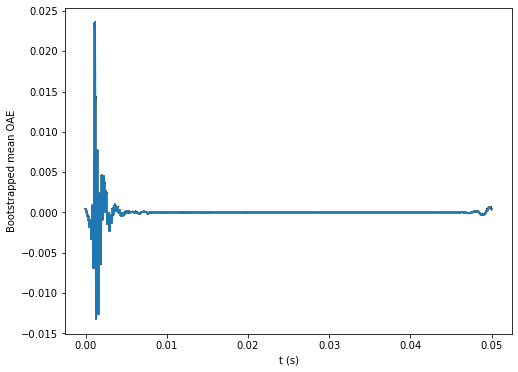

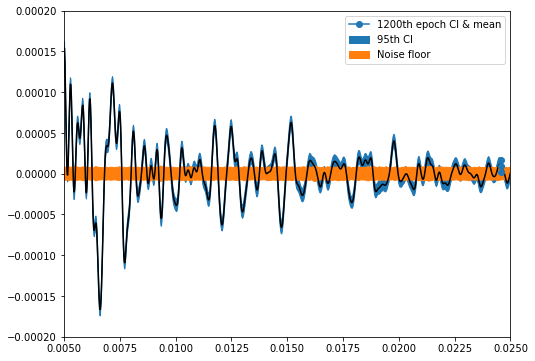

In [694]:
min_a = int(round(1350*0.025,0))
max_a = int(round(1350*0.95,0))
data_each_time = []
for j in range(1350):
    OAE = removed_epochs[:,0]
    random = np.random.choice(OAE,450)
    mean = np.mean(random)
    data_each_time.append(mean)

data_each_time = np.array(data_each_time) # just list to array
data_indices = np.argsort(data_each_time)
data_sort = np.sort(data_each_time)

mean_min = [data_sort[min_a]]
mean_max = [data_sort[max_a]]

mean_each_time = np.mean(data_each_time)

mean_each_time.tolist()


0.00038872194366848246

In [695]:
min_a = int(round(1350*0.025,0))
max_a = int(round(1350*0.95,0))
mean_min = []
mean_max = []
mean_OAE = []
for i in range(2441):
    data_each_time = []
    for j in range(1350):
        OAE = removed_epochs[:,i]
        random = np.random.choice(OAE,450)
        mean = np.mean(random)
        data_each_time.append(mean)
    
    data_each_time = np.array(data_each_time) # just list to array
    data_undices = np.argsort(data_each_time)
    data_sort = np.sort(data_each_time)
    
    mean_min.append(data_sort.tolist()[min_a])
    mean_max.append(data_sort.tolist()[max_a])
    
    mean_each_time = np.mean(data_sort)
    mean_OAE.append(mean_each_time.tolist())

In [707]:
mean_min = np.array(mean_min)
mean_max = np.array(mean_max)
mean_OAE = np.array(mean_OAE)

0.00038883203490167045

In [703]:
# Noise Floor
noise_f_top = (mean_max - mean_min)/2
noise_f_bottom = (mean_min - mean_max)/2

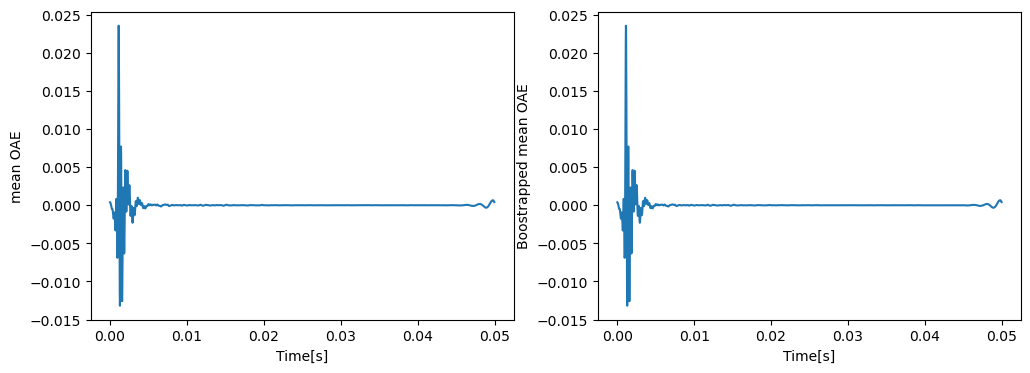

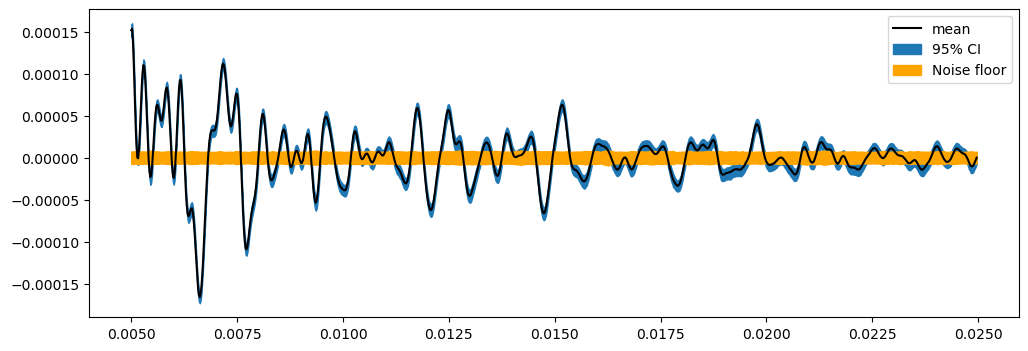

In [704]:
ms_50 = int(len(OAE_1s)*0.050)
fig = plt.figure(figsize = (12,4))
ax = fig.add_subplot(121)
plt.plot(Time[0:ms_50],mean_rej)
plt.xlabel("Time[s]")
plt.ylabel("mean OAE")

ax = fig.add_subplot(122)
plt.plot(Time[0:ms_50],mean_OAE[0:ms_50])
plt.xlabel("Time[s]")
plt.ylabel("Boostrapped mean OAE")


ms_5 = int(len(OAE_1s)*0.005)
ms_25 = int(len(OAE_1s)*0.025)

fig = plt.figure(figsize = (12,4))
ax = fig.add_subplot(111)

ax.plot(Time[ms_5:ms_25],mean_OAE[ms_5:ms_25],color='k')
ax.fill_between(Time[ms_5:ms_25], mean_min[ms_5:ms_25], mean_max[ms_5:ms_25],color='C0') 
ax.fill_between(Time[ms_5:ms_25], noise_f_bottom[ms_5:ms_25], noise_f_top[ms_5:ms_25],color='orange') 

ax.legend(['mean','95% CI','Noise floor'])

### Exercise 3: Noise floor on the OAE spectra 
The OAE signal is often interpreted in the frequency domain. But also in that case, it is important to determine what the noise floor on the spectrum is to be able to interpret whether a specific spectral component in the signal is meaningful. 




<div class="alert alert-info">
    
**Task**
        
* First, plot the magnitude spectrum of the mean OAE (from the 5 to 40 ms window). Note that the first 5 ms of each epoch contain a linear reflection of the click stimulus on the eardrum (and not the echo signal generated by the cochlea), hence we need to omit this information in the spectrum calculation. Similarly, the last 5 ms of the time-domain recording contain stimulus artifact. Should we take the stimulus artifacts into the spectrum calculation, it would appear broadband (just as the energy in the click), whereas spectral components in the OAE only stem from those cochlear regions where the outer-hair-cells were able to reflect the stimulus energy. This energy comes later in time in the recording (i.e. after 5 ms).
    
* You can adopt the previous bootstrapping technique to calculate and plot the 95\% confidence interval on the magnitude spectrum of the OAE between the 5 to 40 ms window.
    
* To generate a base-line noise floor on the magnitude spectrum. We can create an average time-domain noisefloor signal from which we can calculate the spectrum. You can take the following steps: 
    * To generate an average, time-domain noise-floor signal, time-shuffle each bootstrapped mean OAE from the previous bootstrapping loop (np.random.permutation()) to generate 1350 noise signals that have the same statistics as the resampled mean OAEs.
    * Calculate a mean noise-floor signal from these generated noise-floor signals, and then calculate its magnitude spectrum in the same way as you did for the mean OAE signal.

* Plot the noise-floor spectrum on the same plot than the magnitude spectrum of the OAE. Which spectral peaks are significant? Up until which frequency is the hearing functio  
    
    (ii) in this way, you will get 1000 noise-signals from which you can calculate a mean noise-floor signal. (iii) calculate the magnitude spectrum of this noise floor signal in the same way as for the mean OAE signal, and plot both spectra on the same figure. How do you interpret this result? Up until which frequencies is hearing in the tested subject normal?

What your answer should look like.
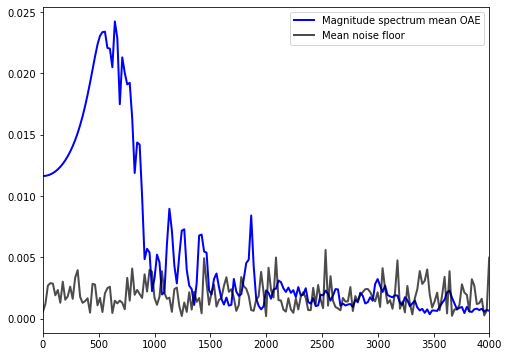

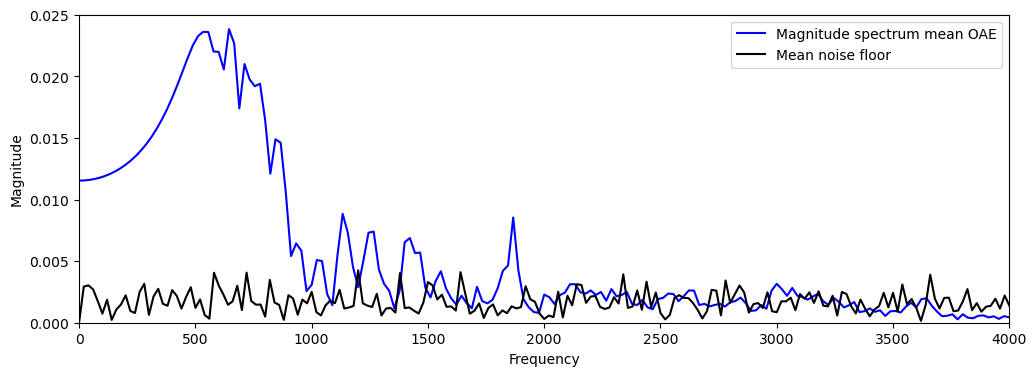

In [772]:
#Your code goes here
fft_mean_OAE = np.fft.fft(mean_rej[int(0.005*FS):])
Amp_mean_OAE = np.abs(fft_mean_OAE)


noise_sigs = []
for i in range(1350):
    time_shuffle = np.random.permutation(mean_OAE)
    noise_sigs.append(time_shuffle)

# Calculate a mean noise-floor signal from these generated noise-floor signals(noise_sigs)
mean_noise_f_sig = np.mean(noise_sigs,axis = 0)
# calculate its magnitude spectrum in the same way as you did for the mean OAE signal.
fft_mean_n = np.fft.fft(mean_noise_f_sig)
Amp_mean_n = np.abs(fft)


noise_f_spec = np.fft.fftshift(Amp_mean_n)
freq = np.fft.fftshift(np.fft.fftfreq(2441,1/FS))

spec = np.fft.fftshift(fft_mean_OAE)
freq_spec = np.fft.fftshift(np.fft.fftfreq(spec.size,1/FS))

fig = plt.figure(figsize = (12,4))
ax = fig.add_subplot(111)
plt.plot(freq_spec,np.abs(spec),color = "b",label = "Magnitude spectrum mean OAE")
plt.plot(freq,noise_f_spec,color = "k",label = "Mean noise floor")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.xlim(0,4000)
plt.ylim(0,0.025)
plt.legend()
plt.show()
